# Implementing diffusivity

In [3]:
import os
import time

import netCDF4 as nc
import numpy as np

import cartopy
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#from Functions.flock_measures import mediod

print(time.ctime(time.time()))

Wed Oct 11 13:35:34 2023


In [4]:
fn = 'toy_data_01.nc'
ds = nc.Dataset(os.path.join(os.pardir, 'Simulations', fn))

lat, lon = ds['lat'][:], ds['lon'][:]
time, id = ds['time'][:], ds['trajectory'][:]
N = np.shape(id)[0] # number of particles (144)
T = np.shape(time)[1] # number of time steps (121)
# shapes: (id,time)

## Displacement

In [5]:
def displacement_xy(X, Y, X0=None, Y0=None, unit='deg'):
    """
    Parameters
    ----------
    X,Y: numpy.ndarray, size=(m,n), unit={degrees,meters}
        m: id, n: time
    X0,Y0: {float, numpy.ndarray}
        initial coordinate(s) at the start

    Returns
    -------
    dx,dy: np.ndarray, size=(m,n), unit={degrees,meters}
        displacement of the center of mass over time for the different axis in m
    """
    if unit not in ['m','deg']:
        print("Unit must be 'm' or 'deg'") # TODO: proper error message
        return
    assert len(set({X.size, Y.size})) == 1
    assert len(set({X.ndim, Y.ndim})) == 1

    X,Y = np.atleast_2d(X), np.atleast_2d(Y)
    if X0 is None:
        X0,Y0 = X[:,0], Y[:,0]
        
    dist_x, dist_y = np.transpose(X.T-X0),np.transpose(Y.T-Y0)
    if unit=='m':
        dx, dy = dist_x, dist_y
    else:
        dy = dist_y*1.11e5
        y_mean = np.transpose(Y.T+Y0)/2
        dx = dist_x*1.11e5*np.cos(np.deg2rad(y_mean))
    return dx, dy

In [6]:
dx,dy = displacement_xy(lon.data,lat.data)

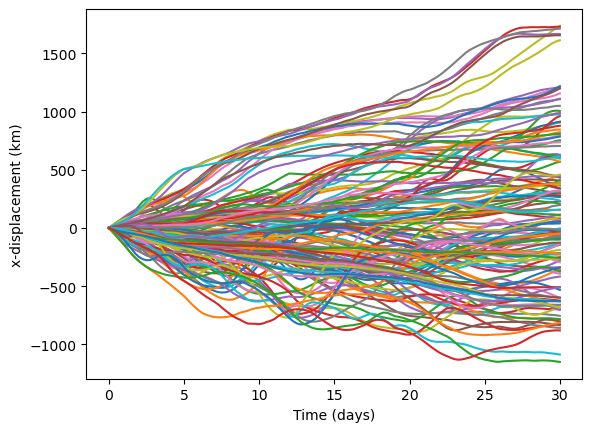

In [7]:
plt.figure()
for i in range(N):
    plt.plot(time[0]/86400,dx[i,:]/1e3)
    
plt.xlabel('Time (days)')
plt.ylabel('x-displacement (km)')
plt.show()

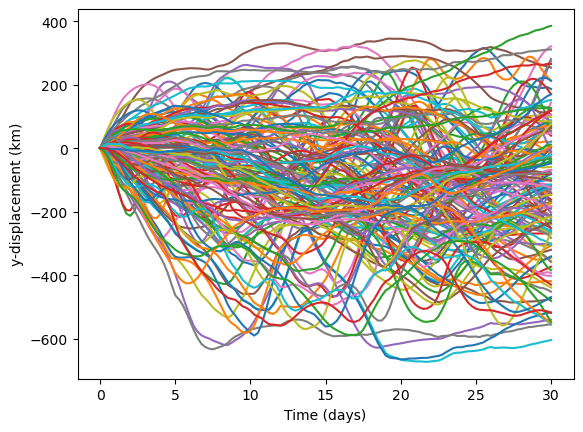

In [8]:
plt.figure()
for i in range(N):
    plt.plot(time[0]/86400,dy[i,:]/1e3)
    
plt.xlabel('Time (days)')
plt.ylabel('y-displacement (km)')
plt.show()

## Dispersion

In [37]:
def dispersion(X, Y, X0=None, Y0=None, unit='deg'):
    dx,dy = displacement_xy(X,Y,X0,Y0,unit)
    s_xx, s_xy, s_yy = np.mean(dx*dx,axis=0), np.mean(dx*dy,axis=0), np.mean(dy*dy,axis=0)
    return s_xx, s_xy, s_yy

In [38]:
s_xx, s_xy, s_yy = dispersion(lon.data,lat.data)

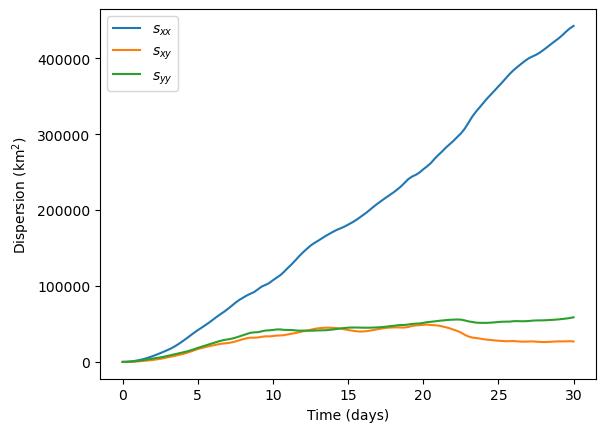

In [39]:
plt.figure()
plt.plot(time[0]/86400,s_xx/1e6,label='$s_{xx}$')
plt.plot(time[0]/86400,s_xy/1e6,label='$s_{xy}$')
plt.plot(time[0]/86400,s_yy/1e6,label='$s_{yy}$')
    
plt.xlabel('Time (days)')
plt.ylabel('Dispersion (km$^2$)')
plt.legend()
plt.show()

In [24]:
# TODO: compute only the residual displacements (and use those to compute the dispersion)

## Diffusivity

In [40]:
def diffusivity_from_dispersion(X, Y, t, X0=None, Y0=None, unit='deg'):
    # TODO: make check if t has the right length
    s_xx, s_xy, s_yy = dispersion(X,Y,X0,Y0,unit)
    k_xx, k_xy, k_yy = 0.5*s_xx/t, 0.5*s_xy/t, 0.5*s_yy/t
    # TODO: compute it as derivatives, or at least delta(s)/delta(t)
    return k_xx, k_xy, k_yy

In [41]:
k_xx, k_xy, k_yy = diffusivity_from_dispersion(lon.data,lat.data,time[0])

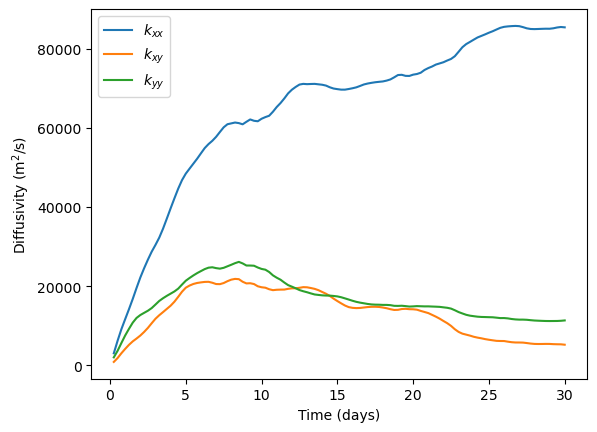

In [43]:
plt.figure()
plt.plot(time[0]/86400,k_xx,label='$k_{xx}$')
plt.plot(time[0]/86400,k_xy,label='$k_{xy}$')
plt.plot(time[0]/86400,k_yy,label='$k_{yy}$')
    
plt.xlabel('Time (days)')
plt.ylabel('Diffusivity (m$^2$/s)')
plt.legend()
plt.show()

In [44]:
# TODO: over which area is this diffusivity now computed? What should the input for this be?

In [45]:
# TODO: compute major + minor principal component of diffusivity tensor